In [120]:
# Import Packages
using Plots
using DelimitedFiles
using Printf

In [135]:
# Define A(z) schedule
function A_f(a)
    a_f = a[:,1]
    a_h = a[:,2]
    a_f ./ a_h
end  

# Define B(z) schedule
function B_f(L, b)
    L_f = L[1]
    L_h = L[2]
    υ = cumsum(b)
    (υ ./ (1 .- υ)) .* (L_f / L_h)
end

# Define Plot 
function plot_f(a, b, L)
    N = size(a)[1]
    z = LinRange(1,N,N)
    A = A_f(a)
    B = B_f(L, b)
    p = Plots.plot(z[1:N-10], [A[1:N-10], B[1:N-10]], label = ["A(z)" "B(z)"])
    xlabel!("z")
    ylabel!("omega")
    display(p)
end

# Check functions
function check_a_f(a)
    A = A_f(a)
    # verify that a has dimension N-by-2 (where N>2) and is non-negative
    size(a)[1] > 2 || error("Error: N <= 2")
    size(a)[2] == 2 || error("Error: a does not have dimension N-by-2")   
    all(>=(0),a) || error("Error: a is not non-negative")
    
    # verify that A = a[:,1]./a[:,2] is monotone decreasing (equation 1 in DFS)
    for i in 1:(size(A)[1]-1)
        A[i,1] >= A[i+1,1] || error("Error: A is not monotone decreasing")
    end
end

function check_b_f(b)
    # verify that b is a vector of dimension N (the same length as A), strictly positive, and that sum(b)==1
    size(b)[1] == size(a)[1] || error("Error: b is not a vector of dimension N (same length as A)")
    all(>=(0),b) || error("Error: b is not non-negative")
    isapprox(sum(b), 1) || error("Error: sum(b) != 1")
end

function check_g_f(g)
    # verify that g is a scalar in (0,1] (as assumed in DFS III.B)
    isa(g, Union{Number,AbstractString,Char,Bool}) && (g <= 1) && (g > 0) || error("Error: g is not a scalar in (0, 1]")
end       
    

# Define solver (manual solver equating the A and B schedule)
function DFS1977solver(a::Array{Float64,2}, b::Array{Float64,1}, L::Array{Float64,1}, g::Float64, print="FALSE")
    
    ### Checks
    check_a_f(a)
    check_b_f(b)
    check_g_f(g)
    
    
    ### Define A & B
    A = A_f(a)
    B = B_f(L, b)
    N = size(a)[1]
    z = LinRange(1,N,N)
    L_f = L[1]
    L_d = L[2]
    
    ### Solve for z_bar & z_bar_star
    # eq 21: z_bar = A^{-1}(gw) --> with w being each element of A,
    # find z_bar by minimizing abs(A - g*w)
    
    z_bar_v = [findmin(abs.(A .- wA .* g))[2] for wA in A]
    z_bar_star_v = [findmin(abs.(A .- wA ./ g))[2] for wA in A]

    ### Solve for λ and λ_star
    λ = [sum(b[1:z_bar_e]) for z_bar_e in z_bar_v]
    λ_star = 1 .- [sum(b[1:z_bar_star_e]) for z_bar_star_e in z_bar_star_v]

    ### Solve for ω_bar
    intersec = findmin(abs.(A .- (1 .- λ_star) ./ (1 .- λ)) .* (L_f / L_d))[2]
    ω_bar = A[intersec]
    ### Solve for z_bar_eq and z_bar_star_eq
    z_bar = findmin(abs.(A .- ω_bar .* g))[2]
    z_bar_star = findmin(abs.(A .- ω_bar ./ g))[2]
    
    if print == "TRUE"
        @printf("\n omega_bar is %.6f, z_bar is %.0f and z_bar_star is %.0f \n \n", ω_bar, z_bar, z_bar_star)
    end
    z_bar, z_bar_star, ω_bar
end

DFS1977solver (generic function with 2 methods)

In [136]:
a = readdlm("DFS1977_example_a.txt", '\t')
b = readdlm("DFS1977_example_b.txt", '\t')[:,1]
L = [1., 1.]

2-element Array{Float64,1}:
 1.0
 1.0

In [137]:
print(DFS1977solver(a, b, L, 1.0), "\n \n")

(86, 86, 1.3061186652154024)
 


In [138]:
print(DFS1977solver(a, b, L, 0.9), "\n \n")

(94, 72, 1.318628976552968)
 


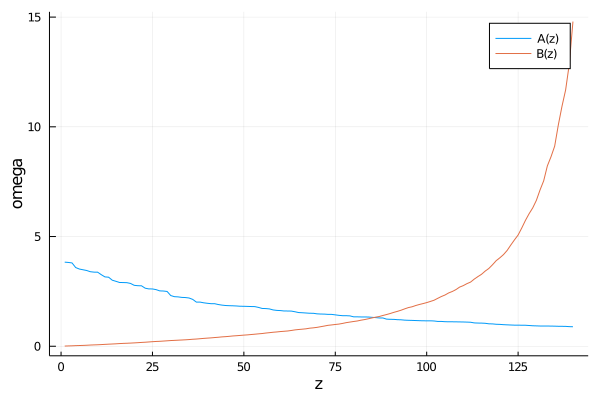

In [139]:
plot_f(a, b, L)

## Comparative Statics

### Uniform Technological Progress
In class, we said that Home's gains from trade can be written as an integral that depends on $\tilde{z}$, $b(z)$, $a(z)$, $a*(z)$, and $\omega$. Similarly for Foreign. Write a function that computes Home welfare and Foreign welfare in equilibrium as a function of a, b, L, and g. I will feed two different a[] arrays to your function to confirm that both countries experience an increase in welfare when Foreign experiences uniform technological progress.

In [151]:
function DFS1977welfare(a::Array{Float64,2}, b::Array{Float64,1}, L::Array{Float64,1}, g::Float64, print="FALSE")
    
    # Set numeraire good
    wh = 1.0
    
    # Obtain z_bar & ω_bar
    z_bar, z_bar_star, ω_bar = DFS1977solver(a, b, L, g)

    # Recover wf 
    wf = wh / ω_bar
    
    # Compute prices assuming perfect competition
    ph = a[:,2] .* wh
    pf = a[:,1] .* wf
    
    # Compute welfare before & after trade for both the home & foreign countries
    welfare_h = log(wh) - sum(b.*log.(ph))
    welfare_h_trade = log(wh) - (sum(b[1:z_bar].*log.(ph[1:z_bar])) + sum(b[z_bar:N].*log.(pf[z_bar:N])))

    welfare_f = log(wf) - sum(b.*log.(pf))
    welfare_f_trade = log(wf) - (sum(b[1:z_bar_star].*log.(ph[1:z_bar_star])) + sum(b[z_bar_star:N].*log.(pf[z_bar_star:N])))
    
    gft_home = welfare_h_trade - welfare_h
    gft_foreign = welfare_f_trade - welfare_f
    
    if print == "TRUE"
        @printf("\n Home Country Welfare before was %.6f before trade and %.6f after trade \n", welfare_h, welfare_h_trade)
        @printf("Foreign Country Welfare before was %.6f before trade and %.6f after trade \n", welfare_f, welfare_f_trade)
        @printf("\n Home Country Welfare Gains from trade: %.6f \n", gft_home)
        @printf("Foreign Country Welfare Gains from trade: %.6f \n", gft_foreign)
    end
    gft_home, gft_foreign

end


DFS1977welfare (generic function with 2 methods)

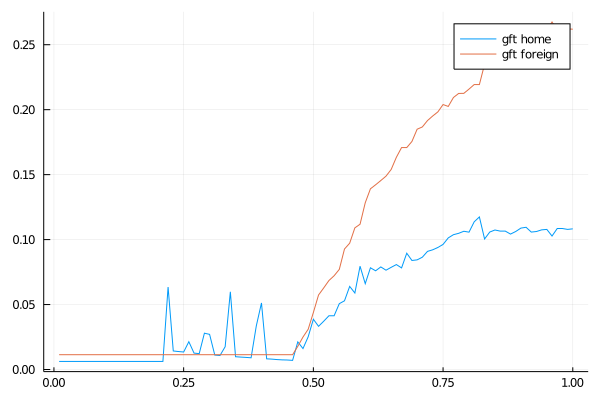

In [153]:
# Gains from Trade for different g
vector = LinRange(0.01,1,100)
home_gft = [DFS1977welfare(a, b, L, v)[1] for v in vector]
foreign_gft = [DFS1977welfare(a, b, L, v)[2] for v in vector]
plot(vector, [home_gft, foreign_gft],  label = ["gft home" "gft foreign"])

In [154]:
print("Initial Solution \n \n")
print(DFS1977welfare(a, b, L, 1.0))
# New a such that a* is uniformly lower (foreign more productive)
a_progress = copy(a)
a_progress[:,1] = a_progress[:,1] .- 0.5

print("\n \n Foreign uniformly more productive \n \n ")
print(DFS1977welfare(a_progress, b, L, 1.0))

Initial Solution 
 
(0.10827614814227104, 0.2619646838695913)
 
 Foreign uniformly more productive 
 
 (0.18999686641236369, 0.18214547478291254)

## Discussion : relationship between the volume of trade and each country's gains from trade

What is the relationship between the volume of trade and each country's gains from trade in this model? Use your solver to produce an example of different equilibria (with the same L, L*, and g<1) that exhibit the same volume of trade and different gains from trade. If you also hold fixed the b schedule, can you produce such an example? Why or why not? What can be said about the magnitude of the gains from trade in this model if we observe the equilibrium volume of trade and do not observe autarky prices?

### On the relationship between volume of trade and GFT - the role of trade costs g

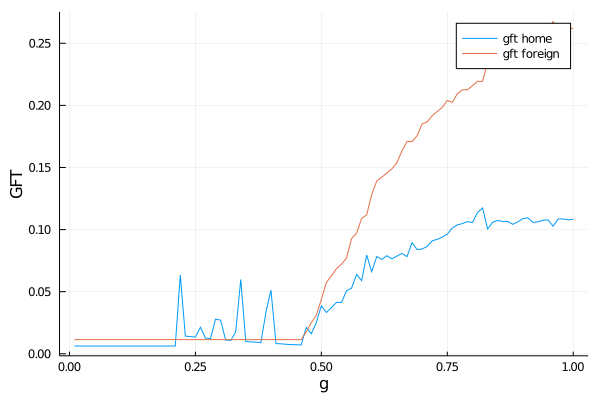

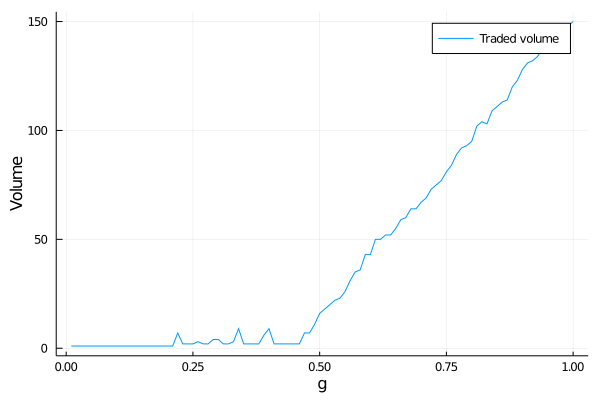

In [166]:
N = size(A)[1]
vector = LinRange(0.01,1,100)
home_gft = [DFS1977welfare(a, b, L, v)[1] for v in vector]
foreign_gft = [DFS1977welfare(a, b, L, v)[2] for v in vector]
z_bar = [DFS1977solver(a, b, L, v)[1] for v in vector]
z_bar_star = [DFS1977solver(a, b, L, v)[2] for v in vector]
volume = z_bar_star .+ (N .- z_bar)

p1 = plot(vector, [home_gft, foreign_gft], label = ["gft home" "gft foreign"])
xlabel!("g")
ylabel!("GFT")
display(p1)
p2 = plot(vector, [volume], label = "Traded volume")
xlabel!("g")
ylabel!("Volume")
display(p2)

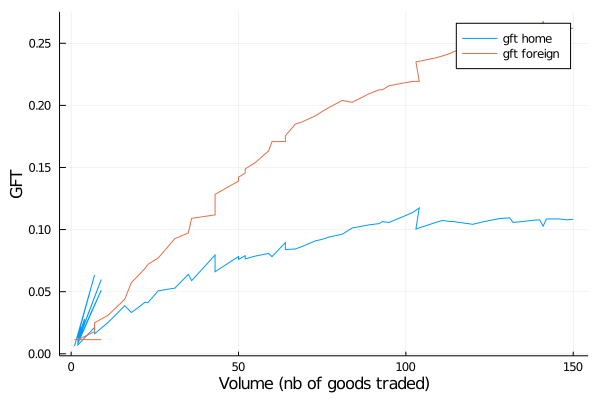

In [167]:
p3 = plot(volume, [home_gft, foreign_gft], label = ["gft home" "gft foreign"])
xlabel!("Volume (nb of goods traded)")
ylabel!("GFT")
display(p3)

As one can see on the graph above plotting the correlation between gains from trade and volume traded (number of goods z traded), their is a positive relationship between gains from trade and volume traded, when the volume traded depends on trading costs $g$. Intuitively, high trading costs (low g) prevent some trade to happen, and we proved before that countries only benefit from trade.

### On the relationship between volume traded and gft - fixed g

Use your solver to produce an example of different equilibria (with the same L, L*, and g<1) that exhibit the same volume of trade and different gains from trade. If you also hold fixed the b schedule, can you produce such an example? Why or why not? What can be said about the magnitude of the gains from trade in this model if we observe the equilibrium volume of trade and do not observe autarky prices?

Intuitively, in order to observe the same volume of trade, for a given $g, L, L^*$, but different $a, b$, if we change a, we need to adjust b in return, such that the $z_bar$ and $z_bar_star$ are the same.

If b is fixed, then you cannot produce such an example because a change in a will always lead to a change in the volume traded


If we observe the equilibrium volume of trade but neither the autarky prices, nor which goods are traded, then we can't say much about the magnitude of the gains from trade : if we don't know b, then we've just shown that we could have an equilibrium with the same traded volumes but different gains from trade, as there is a n:1 mapping between (a,b) and traded volumes. Observing autarky prices ($omega$), however, allows us to pin down the exact $z_bar$ and $z_bar_star$ and therefore, knowing a, the gains from trade.
More simply, gains from trade correspond to the area between $\bar{\omega}$ and $A / g$ ($A * g$) for home (foreign), so we need to know where to start integrating. The lower $z_bar$ and $z_bar_home$ (for a given $z_bar - z_bar_home$) the larger gains from trade for home and the lower gains from trade for foreign.

In [203]:
### Same traded volume and different gains from trade by simply moving a

amax = findmax(A_f(a))[1]
a_v2 = copy(a)
# Foreign is everywhere less efficient than home
a_v2[:,1] .= amax
z_bar, z_bar_star, ω = DFS1977solver(a_v2, b, L, 0.9)
print(z_bar - z_bar_star, "\n")
print(DFS1977solver(a_v2, b, L, 0.9), "\n")
print(DFS1977welfare(a_v2, b, L, 0.9), "\n \n")
# Foreign is everywhere more efficient than home
amin = findmin(A_f(a))[1]
a_v3 = copy(a)
a_v3[:,1] .= amin + 0.8
z_bar, z_bar_star, ω = DFS1977solver(a_v3, b, L, 0.9)
print(z_bar - z_bar_star, "\n")
print(DFS1977solver(a_v3, b, L, 0.9), "\n")
print(DFS1977welfare(a_v3, b, L, 0.9), "\n \n")
print("Lower z_bar, higher gft for home because traded goods are goods where home is not good from an absolute perspective")

31
(126, 95, 4.077547790802379)
(0.029432968915465096, 0.3872122800410118)
 
31
(110, 79, 1.9652793620014237)
(0.07328211251201722, 0.2930946139588701)
 
Lower z_bar, higher gft for home because traded goods are goods where home is not good from an absolute perspective

The reason why you can produce such an example without moving b is that

In [194]:
A = A_f(a)
findmin(A)[1]

0.8009315404751105

In [ ]:
N = size(A)[1]
amax = max(A[:,2])

b = ones(N)
home_gft = [DFS1977welfare(a, b, L, 0.9)[1] for v in vector]
foreign_gft = [DFS1977welfare(a, b, L, v)[2] for v in vector]
z_bar = [DFS1977solver(a, b, L, v)[1] for v in vector]
z_bar_star = [DFS1977solver(a, b, L, v)[2] for v in vector]
volume = z_bar_star .+ (N .- z_bar)

p1 = plot(vector, [home_gft, foreign_gft], label = ["gft home" "gft foreign"])
xlabel!("g")
ylabel!("GFT")
display(p1)
p2 = plot(vector, [volume], label = "Traded volume")
xlabel!("g")
ylabel!("Volume")
display(p2)

Intuitively: if you hold b (demand schedule) fixed, then, for a given g, because you only degree of freedom is through a, you could get different $z\_bar$ and $z\_bar\_star$ (potentially?), leading to different gains from trade, but this would also imply different traded volumes...

If b is not fixed, then you could try to adjust changes in traded volumes resulting from moving a, but moving b too such that $(z\_bar - z\_bar\_star)$ is the same but the gains from trade is not.

Ask: is "volumes from trade" the number of goods traded, or the number of goods*quantity.

Potentially special case if b = constant



I think you could 

Gains from trade do not depend on b, conditional on volumes traded


See terrible graph written on my ipad : could adjust A in response to adjusting B such that same zbar and zbarstar, but different inclinations of A lead to different gains from trade.